## Data engineering

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

In [2]:
df_company = pd.read_csv('data/3_geolocation.csv', index_col=0)

In [3]:
shape = df_company.shape
print(shape)
print(f"No. rows: {shape[0]}")
print(f"No. columns: {shape[1]}")

(25, 25)
No. rows: 25
No. columns: 25


In [4]:
df_company.dtypes

vat                  int64
name                object
address             object
zipcode              int64
city                object
phone              float64
email               object
startdate           object
employees          float64
addressco           object
industrycode         int64
industrydesc        object
creditbankrupt        bool
productionunits     object
2021               float64
2020               float64
2019               float64
2018               float64
2017               float64
2016               float64
2015               float64
2014               float64
2013               float64
latitude           float64
longitude          float64
dtype: object

In [5]:
numerical_cols = df_company.select_dtypes(np.number).columns
numerical_cols

Index(['vat', 'zipcode', 'phone', 'employees', 'industrycode', '2021', '2020',
       '2019', '2018', '2017', '2016', '2015', '2014', '2013', 'latitude',
       'longitude'],
      dtype='object')

Really, only `employees` is proper numerical. And the coordinates but eh.

Since scraping financial data from Proff.dk, all of that is numerical as well.

In [6]:
employees = df_company.employees
print(f'Missing values:\t{employees.isna().sum()}')
print(f'Mean:\t\t{employees.mean()}')
print(f'Median:\t\t{employees.median()}')
print(f'Mode:\n{employees.mode()}')
print(f'Min:\t\t{employees.min()}')
print(f'Max:\t\t{employees.max()}')
print(f'Range:\t\t{employees.max() - employees.min()}')
print(f'Variance:\t\t{employees.var()}')
print(f'Standard deviation:\t{employees.std()}')

Missing values:	2
Mean:		1436.4347826086957
Median:		83.0
Mode:
0         1.0
1         3.0
2         8.0
3        15.0
4        20.0
5        36.0
6        40.0
7        42.0
8        46.0
9        59.0
10       72.0
11       83.0
12       87.0
13      166.0
14      171.0
15      175.0
16      266.0
17      297.0
18     1464.0
19     1855.0
20     2340.0
21     3642.0
22    22150.0
Name: employees, dtype: float64
Min:		1.0
Max:		22150.0
Range:		22149.0
Variance:		21262119.893280633
Standard deviation:	4611.086628255929


Mode is all of them because no one value is repeated. They all have different amounts of employees.

In [7]:
# instead of printing everything separately
# .describe() generates descriptive statistics
# not NaN count
# median is same as 50% quantile
employees.describe()

count       23.000000
mean      1436.434783
std       4611.086628
min          1.000000
25%         38.000000
50%         83.000000
75%        281.500000
max      22150.000000
Name: employees, dtype: float64

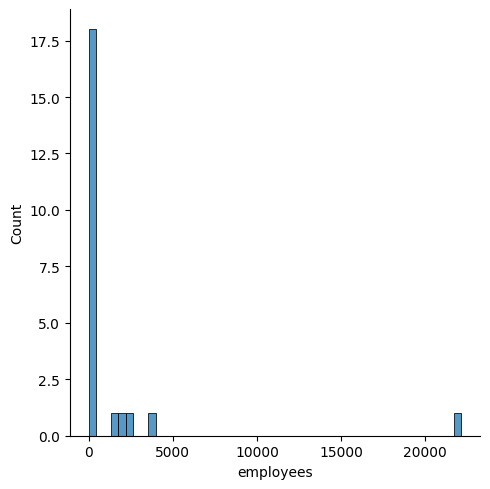

In [8]:
sns.displot(employees, kind='hist', bins=50) # histogram is default kind

Mean is **HEAVILY** skewed because of larger companies like **Novo Nordisk**.

It absolutely does **not** follow normal distribution, but our sample size is tiny, and variance is humongous.

Let's remove outliers and replace missing values with **median**.

(*Since scraping employee data from Proff.dk, we no longer have missing values.*)

In [9]:
lo = employees.quantile(.05)
hi = employees.quantile(.95)
print(lo, hi)
print(employees.quantile([.05,.5,.95])) # other way to get those values. 0.5 included for fun because it's also the median.

3.5000000000000004 3511.7999999999984
0.05       3.5
0.50      83.0
0.95    3511.8
Name: employees, dtype: float64


In [10]:
no_outliers = employees[(employees < hi) & (employees > lo)]
print(no_outliers)
print(no_outliers.describe())
# median is the same

Dynatest A/S                           36.0
Eriksholm Research Centre, Oticon      42.0
Formpipe                               87.0
PFA                                  1464.0
Topdanmark                              8.0
KMD A/S                              1855.0
NorthTech ApS                          20.0
Alpha Solutions                        59.0
Dafolo                                 83.0
Netcompany A/S                       2340.0
Wash World                             72.0
Carve                                  46.0
GroupM                                266.0
Brøndbyernes I.F.                     297.0
PreCure                                15.0
Wilke                                 175.0
OOONO                                  40.0
Elbek & Vejrup                        171.0
Ellab                                 166.0
Name: employees, dtype: float64
count      19.000000
mean      381.157895
std       690.271707
min         8.000000
25%        41.000000
50%        83.000000
75%   

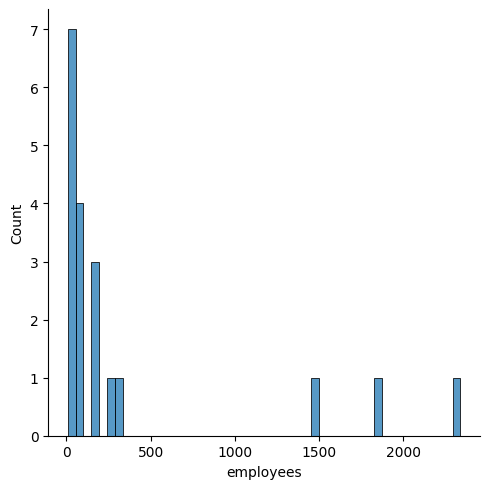

In [11]:
sns.displot(no_outliers, bins=50)

Not much really changed from the previous plot.

In [12]:
df_company.employees.fillna(employees.median(), inplace=True) # median has skipna=True by default
df_company.employees

Dynatest A/S                            36.0
Eriksholm Research Centre, Oticon       42.0
Formpipe                                87.0
Novo Nordisk                         22150.0
PFA                                   1464.0
Topdanmark                               8.0
KMD A/S                               1855.0
NorthTech ApS                           20.0
Alpha Solutions                         59.0
Dafolo                                  83.0
Nuuday A/S                            3642.0
Netcompany A/S                        2340.0
Wash World                              72.0
Carve                                   46.0
GroupM                                 266.0
Brøndbyernes I.F.                      297.0
Meew                                    83.0
Funelo                                  83.0
PreCure                                 15.0
Wilke                                  175.0
OOONO                                   40.0
Elbek & Vejrup                         171.0
Ellab     

## Encoding text data
The only real labels I can see are the *city names*, and *industry types*. Cities are kind of already encoded to numerical with ZIP codes, and the industries already have a code used in the API. But let's one-hot encode it anyway.

In [13]:
ohe = OneHotEncoder(sparse_output=False)

In [14]:
encoded_data = ohe.fit_transform(df_company[['city', 'industrydesc']])
encoded_data

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.,

In [15]:
encoded_df = pd.DataFrame(encoded_data, columns=ohe.get_feature_names_out(['city', 'industrydesc'])).set_index(df_company.index)
# the problem was that the encoded df didn't have the same index as the original df
# so the concat would append new rows instead of replacing the old ones
encoded_df.head()

,city_Aarhus N,city_Allinge,city_Bagsværd,city_Ballerup,city_Brøndby,city_Frederikshavn,city_Herlev,city_Hillerød,city_Kongens Lyngby,city_København K,...,industrydesc_Finansielle holdingselskaber,industrydesc_Fremstilling af farmaceutiske præparater,industrydesc_Fremstilling af medicinske og dentale instrumenter samt udstyr hertil,industrydesc_Ikke-finansielle holdingselskaber,industrydesc_Ikke-finansielle hovedsæders virksomhed,industrydesc_Konsulentbistand vedrørende informationsteknologi,industrydesc_Markedsanalyse og offentlig meningsmåling,industrydesc_Sportsklubber,industrydesc_Udgivelse af bøger,industrydesc_Uoplyst
Dynatest A/S,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Eriksholm Research Centre, Oticon",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Formpipe,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Novo Nordisk,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PFA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_processed = pd.concat([df_company, encoded_df], axis=1)
df_processed.head()

,vat,name,address,zipcode,city,phone,email,startdate,employees,addressco,...,industrydesc_Finansielle holdingselskaber,industrydesc_Fremstilling af farmaceutiske præparater,industrydesc_Fremstilling af medicinske og dentale instrumenter samt udstyr hertil,industrydesc_Ikke-finansielle holdingselskaber,industrydesc_Ikke-finansielle hovedsæders virksomhed,industrydesc_Konsulentbistand vedrørende informationsteknologi,industrydesc_Markedsanalyse og offentlig meningsmåling,industrydesc_Sportsklubber,industrydesc_Udgivelse af bøger,industrydesc_Uoplyst
Dynatest A/S,20318872,A/S DYNATEST ENGINEERING,Generatorvej 21,2730,Herlev,NaN,NaN,15/10 - 1981,36.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"Eriksholm Research Centre, Oticon",50091015,PROPOLIS RESEARCH CENTRE A/S,Lille Veksøvej 11,3670,Veksø Sjælland,NaN,NaN,10/09 - 1974,42.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Formpipe,26366216,FORMPIPE LASERNET A/S,Lautrupvang 1,2750,Ballerup,43660210.0,admin.lasernet@formpipe.com,13/12 - 2001,87.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Novo Nordisk,24256790,NOVO NORDISK A/S,Novo Alle 1,2880,Bagsværd,44448888.0,NaN,28/11 - 1931,22150.0,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PFA,31050162,PFA BANK A/S,Sundkrogsgade 4,2100,København Ø,70808500.0,post@pfabank.dk,02/11 - 2007,1464.0,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [17]:
df_processed.drop(['city', 'industrydesc'], axis=1, inplace=True)

In [18]:
df_processed.to_csv('data/5_processed.csv')